In [1]:
import zipfile,os, shutil, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [2]:
# Extract dataset 

zip_dir = Path(r"C:/Users/Ventha/Downloads/RiceLeafZips/Data")   
extract_to = Path(r"C:/Users/Ventha/Downloads/RiceLeafDataset") 
extract_to.mkdir(parents=True, exist_ok=True)

for zfile in zip_dir.glob("*.zip"):
    print("Extracting:", zfile.name)
    with zipfile.ZipFile(zfile, "r") as z:
        z.extractall(extract_to)

print("\nExtraction complete.")

Extracting: Bacterial leaf blight-20200814T055237Z-001.zip
Extracting: Brown spot-20200814T055208Z-001.zip
Extracting: Leaf smut-20200814T055530Z-001.zip

Extraction complete.


In [3]:
# Load the data

DATA_DIR = Path(r"C:/Users/Ventha/Downloads/RiceLeafDataset")   
OUTPUT_DIR = Path("output"); OUTPUT_DIR.mkdir(exist_ok=True)

IMG_SIZE = (224,224)
BATCH_SIZE = 8
EPOCHS = 12
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Classes found: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Image counts per class: {'Bacterial leaf blight': 40, 'Brown spot': 40, 'Leaf smut': 39}


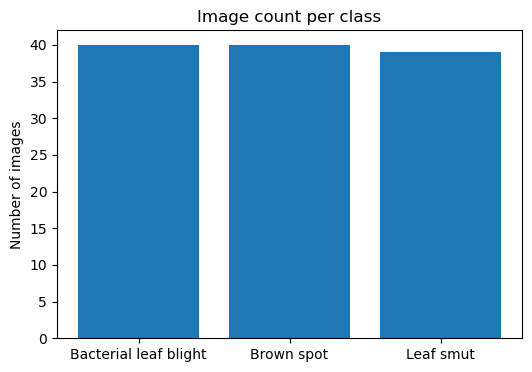

In [4]:
# Dataset Info & EDA

classes = [p.name for p in sorted(DATA_DIR.iterdir()) if p.is_dir()]
print("Classes found:", classes)

counts = {c: len(list((DATA_DIR/c).glob("*"))) for c in classes}
print("Image counts per class:", counts)

plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values())
plt.title("Image count per class") 
plt.ylabel("Number of images"); plt.show()

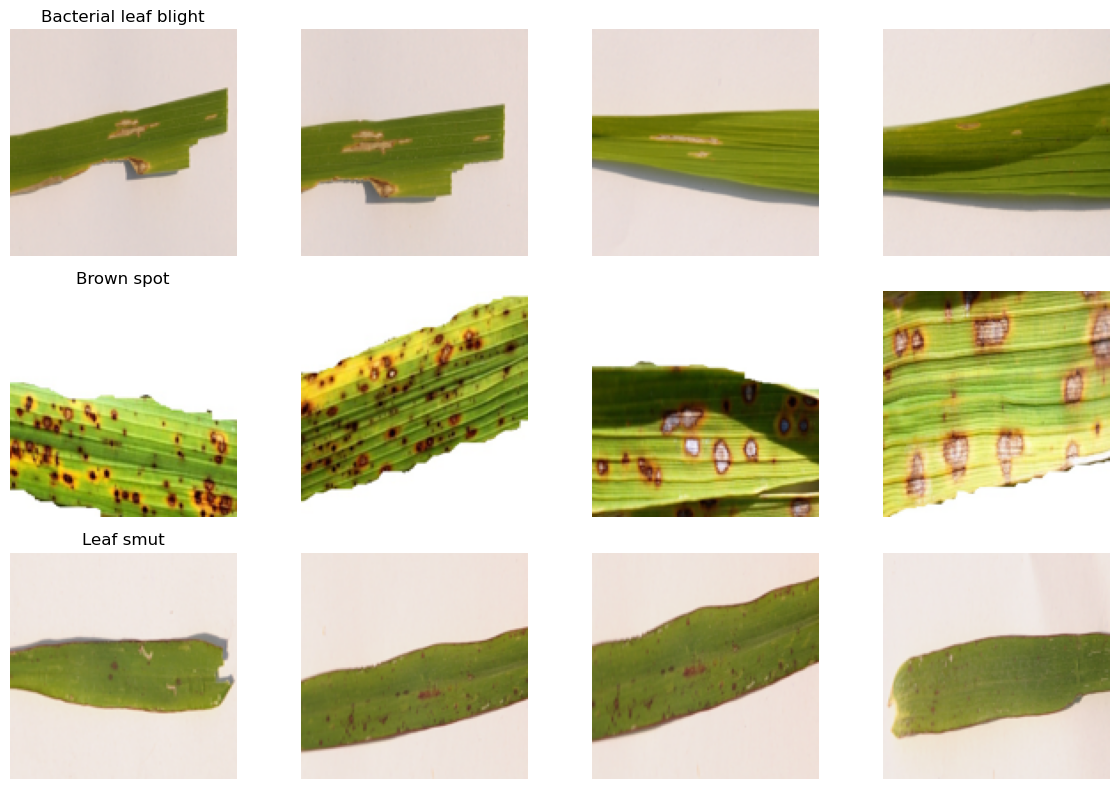

In [5]:
# Show sample images

fig, axs = plt.subplots(len(classes), 4, figsize=(12, 8))
for i, c in enumerate(classes):
    imgs = list((DATA_DIR/c).glob("*"))[:4]
    for j, img_path in enumerate(imgs):
        img = Image.open(img_path).convert("RGB").resize((128,128))
        axs[i,j].imshow(img)
        axs[i,j].axis("off")
        if j==0: axs[i,j].set_title(c)
plt.tight_layout(); plt.show()

In [6]:
# Train/val/Test Split 

SPLIT_DIR = Path("data_split")
if not SPLIT_DIR.exists():
    for c in classes:
        files = list((DATA_DIR/c).glob("*"))
        train_val, test = train_test_split(files, test_size=0.15, random_state=RANDOM_SEED)
        train, val = train_test_split(train_val, test_size=0.1765, random_state=RANDOM_SEED)  
        for split, file_list in [("train",train), ("val",val), ("test",test)]:
            target = SPLIT_DIR/split/c
            target.mkdir(parents=True, exist_ok=True)
            for f in file_list:
                shutil.copy(f, target/f.name)

In [7]:
# Generators 

train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True).flow_from_directory(
    SPLIT_DIR/"train", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical")

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    SPLIT_DIR/"val", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical")

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    SPLIT_DIR/"test", target_size=IMG_SIZE, batch_size=1, class_mode="categorical", shuffle=False)

class_indices = train_gen.class_indices
print("Class indices:", class_indices)

Found 74 images belonging to 3 classes.
Found 21 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Class indices: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


C:\Users\ventha\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ventha\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2838 - loss: 1.7111 - val_accuracy: 0.3333 - val_loss: 1.3301
Epoch 2/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 883ms/step - accuracy: 0.3649 - loss: 1.2234 - val_accuracy: 0.3333 - val_loss: 1.0879
Epoch 3/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 967ms/step - accuracy: 0.3243 - loss: 1.3134 - val_accuracy: 0.2381 - val_loss: 1.1061
Epoch 4/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 908ms/step - accuracy: 0.4595 - loss: 1.0021 - val_accuracy: 0.3333 - val_loss: 1.1757
Epoch 5/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 912ms/step - accuracy: 0.4324 - loss: 1.0739 - val_accuracy: 0.2857 - val_loss: 1.0695
Epoch 6/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 895ms/step - accuracy: 0.4595 - loss: 1.0360 - val_accuracy: 0.5238 - val_loss: 1.3566
Epoch 7/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 909ms/step - accuracy: 0.5135 - loss: 1.1153 - val_accuracy: 0.6667 - val_loss: 0.9936
Epoch 8/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 967ms/step - accuracy: 0.5811 - loss: 0.9185 - val_accuracy: 

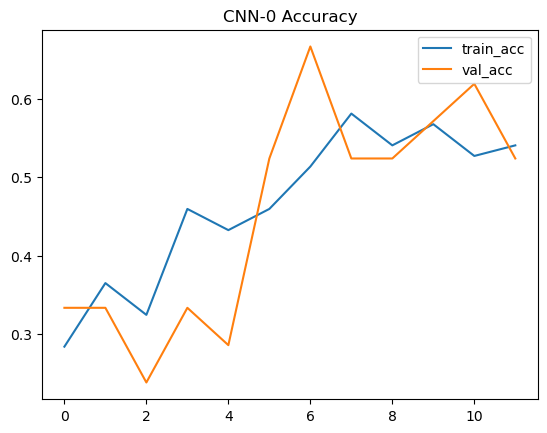

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
CNN-0 Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.38      0.55         8
           Brown spot       0.50      0.88      0.64         8
            Leaf smut       0.57      0.50      0.53         8

             accuracy                           0.58        24
            macro avg       0.69      0.58      0.57        24
         weighted avg       0.69      0.58      0.57        24



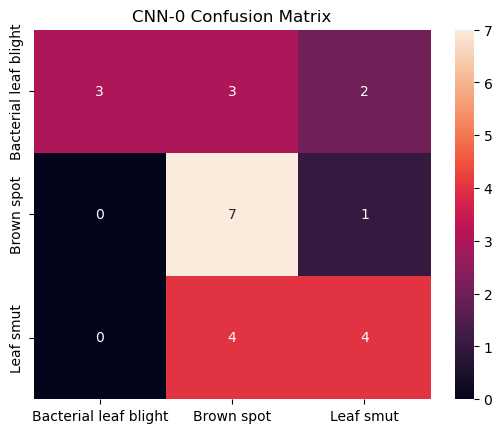

In [8]:
# CNN-0:Simple CNN

cnn0 = models.Sequential([
    layers.Conv2D(16,(3,3),activation="relu",input_shape=IMG_SIZE+(3,)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32,activation="relu"),
    layers.Dense(len(classes),activation="softmax")
])
cnn0.compile(optimizer=optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

hist0 = cnn0.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

plt.plot(hist0.history["accuracy"], label="train_acc")
plt.plot(hist0.history["val_accuracy"], label="val_acc")
plt.title("CNN-0 Accuracy"); plt.legend(); plt.show()

y_true = test_gen.classes
y_pred = np.argmax(cnn0.predict(test_gen), axis=1)
print("CNN-0 Report:\n", classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title("CNN-0 Confusion Matrix"); plt.show()



### Insights:
* model improves over epochs but is inconsistent.
* Major confusion between all classes, with weak class separation.

C:\Users\ventha\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3243 - loss: 1.9198 - val_accuracy: 0.3333 - val_loss: 1.5415
Epoch 2/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4189 - loss: 1.1208 - val_accuracy: 0.4286 - val_loss: 1.0848
Epoch 3/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4865 - loss: 1.0402 - val_accuracy: 0.4286 - val_loss: 1.0749
Epoch 4/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4054 - loss: 1.0373 - val_accuracy: 0.5238 - val_loss: 1.0944
Epoch 5/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3514 - loss: 1.0246 - val_accuracy: 0.3333 - val_loss: 1.1321
Epoch 6/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4459 - loss: 1.0197 - val_accuracy: 0.3333 - val_loss: 1.1086
Epoch 7/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 984ms/step - accuracy: 0.4595 - loss: 1.0118 - val_accuracy: 0.3810 - val_loss: 1.0959
Epoch 8/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4730 - loss: 1.0349 - val_accuracy: 0.4286 - val_lo

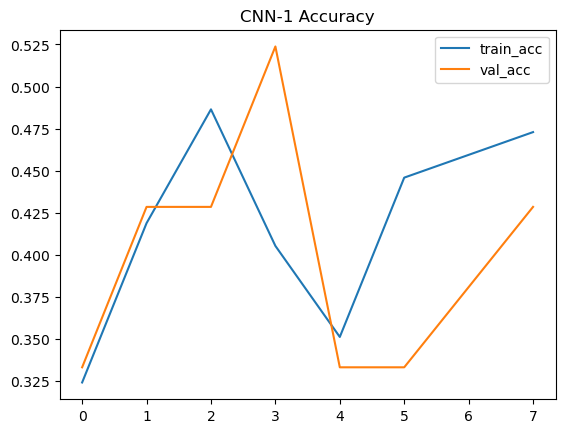

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
CNN-1 Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.12      0.22         8
           Brown spot       0.50      0.62      0.56         8
            Leaf smut       0.38      0.62      0.48         8

             accuracy                           0.46        24
            macro avg       0.63      0.46      0.42        24
         weighted avg       0.63      0.46      0.42        24



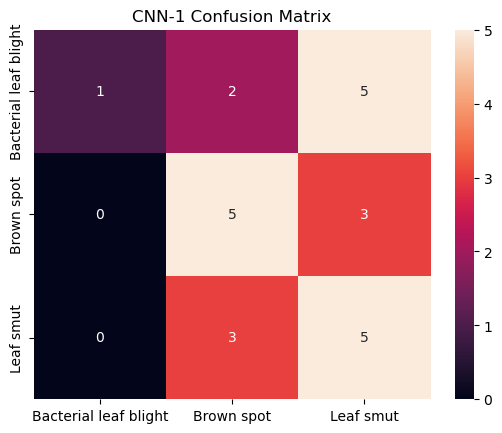

In [9]:
# CNN-1: Shallow

cnn1 = models.Sequential([
    layers.Conv2D(32,(3,3),activation="relu",input_shape=IMG_SIZE+(3,)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(len(classes),activation="softmax")
])
cnn1.compile(optimizer=optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

hist1 = cnn1.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

plt.plot(hist1.history["accuracy"], label="train_acc")
plt.plot(hist1.history["val_accuracy"], label="val_acc")
plt.title("CNN-1 Accuracy"); plt.legend(); plt.show()

y_pred = np.argmax(cnn1.predict(test_gen), axis=1)
print("CNN-1 Report:\n", classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title("CNN-1 Confusion Matrix"); plt.show()


### Insights:
* Slightly better on Brown spot and Leaf smut, but Bacterial leaf blight often misclassified
* Fluctuates throughout training and Model still has significant class confusion.

C:\Users\ventha\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3649 - loss: 1.6202 - val_accuracy: 0.3333 - val_loss: 1.1701
Epoch 2/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3649 - loss: 1.4285 - val_accuracy: 0.4286 - val_loss: 1.1142
Epoch 3/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4730 - loss: 1.0956 - val_accuracy: 0.6190 - val_loss: 1.0934
Epoch 4/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4189 - loss: 1.1161 - val_accuracy: 0.4286 - val_loss: 1.1055
Epoch 5/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4054 - loss: 1.1011 - val_accuracy: 0.4286 - val_loss: 1.1326
Epoch 6/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5405 - loss: 0.9957 - val_accuracy: 0.4286 - val_loss: 1.1079
Epoch 7/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5135 - loss: 0.9661 - val_accuracy: 0.5714 - val_loss: 1.0887
Epoch 8/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4865 - loss: 0.9594 - val_accuracy: 0.5714 - val_loss:

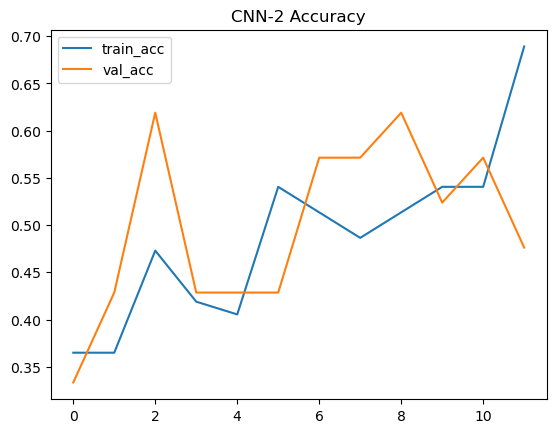

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
CNN-2 Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       0.71      0.62      0.67         8
           Brown spot       0.67      0.50      0.57         8
            Leaf smut       0.45      0.62      0.53         8

             accuracy                           0.58        24
            macro avg       0.61      0.58      0.59        24
         weighted avg       0.61      0.58      0.59        24



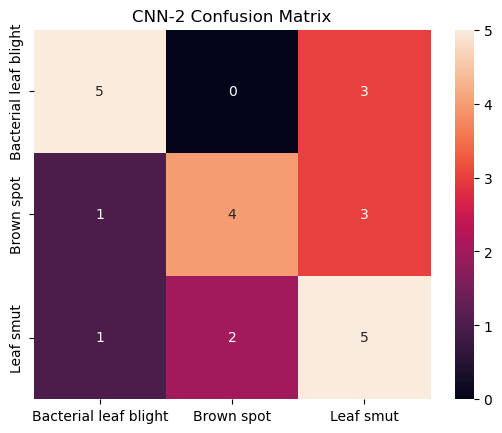

In [10]:
# CNN-2: Medium + Dropout

cnn2 = models.Sequential([
    layers.Conv2D(32,(3,3),activation="relu",input_shape=IMG_SIZE+(3,)),
    layers.MaxPooling2D(),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(classes),activation="softmax")
])
cnn2.compile(optimizer=optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

hist2 = cnn2.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

plt.plot(hist2.history["accuracy"], label="train_acc")
plt.plot(hist2.history["val_accuracy"], label="val_acc")
plt.title("CNN-2 Accuracy"); plt.legend(); plt.show()

y_pred = np.argmax(cnn2.predict(test_gen), axis=1)
print("CNN-2 Report:\n", classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title("CNN-2 Confusion Matrix"); plt.show()

### Insights:
* More balanced performance.First time all classes, including Leaf smut, are correctly identified, but some confusion remains between classes...


Epoch 1/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4054 - loss: 1.4502 - val_accuracy: 0.5238 - val_loss: 0.9961
Epoch 2/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5000 - loss: 1.1683 - val_accuracy: 0.6667 - val_loss: 0.9025
Epoch 3/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4865 - loss: 0.9675 - val_accuracy: 0.5714 - val_loss: 0.8676
Epoch 4/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5000 - loss: 0.9707 - val_accuracy: 0.7143 - val_loss: 0.7081
Epoch 5/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6892 - loss: 0.7706 - val_accuracy: 0.7143 - val_loss: 0.6552
Epoch 6/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6757 - loss: 0.8173 - val_accuracy: 0.8095 - val_loss: 0.6359
Epoch 7/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7432 - loss: 0.6432 - val_accuracy: 0.7619 - val_loss: 0.6065
Epoch 8/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8108 - loss: 0.5784 - val_accuracy: 0.7619 - val_loss:

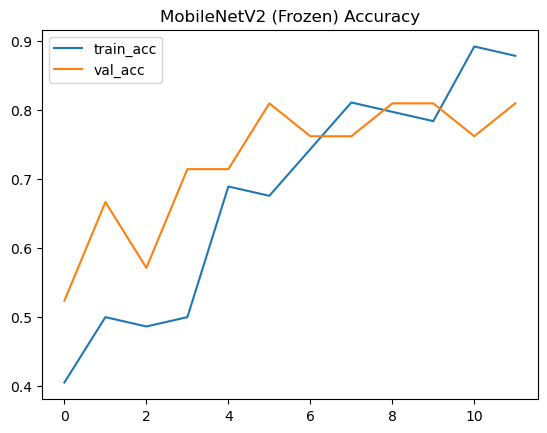

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
MobileNetV2 Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       0.80      1.00      0.89         8
           Brown spot       0.78      0.88      0.82         8
            Leaf smut       0.80      0.50      0.62         8

             accuracy                           0.79        24
            macro avg       0.79      0.79      0.78        24
         weighted avg       0.79      0.79      0.78        24



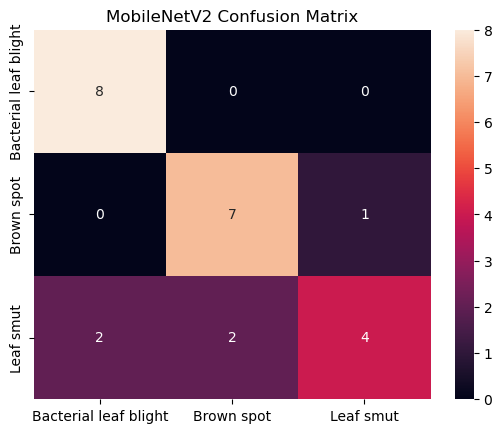

In [11]:
# MobileNetV2 (Frozen)

base = applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
base.trainable = False

inp = layers.Input(shape=IMG_SIZE+(3,))
x = base(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(len(classes), activation="softmax")(x)
mn_model = models.Model(inputs=inp, outputs=out)

mn_model.compile(optimizer=optimizers.Adam(1e-4),
                 loss="categorical_crossentropy", metrics=["accuracy"])

hist_mn = mn_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                       callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

plt.plot(hist_mn.history["accuracy"], label="train_acc")
plt.plot(hist_mn.history["val_accuracy"], label="val_acc")
plt.title("MobileNetV2 (Frozen) Accuracy"); plt.legend(); plt.show()

y_pred = np.argmax(mn_model.predict(test_gen), axis=1)
print("MobileNetV2 Report:\n", classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title("MobileNetV2 Confusion Matrix"); plt.show()

### Insights :
* Most predictions are correct for all classes with good accuracy; especially strong on Bacterial leaf blight and Brown spot.
* Consistent, strong learning curves reflecting robust model performance.

                    Model  Accuracy  Precision    Recall        F1
3    MobileNetV2 (Frozen)  0.791667   0.792593  0.791667  0.775934
0     CNN-0 (Very Simple)  0.583333   0.690476  0.583333  0.571717
2  CNN-2 (Medium+Dropout)  0.583333   0.611833  0.583333  0.588137
1         CNN-1 (Shallow)  0.458333   0.628205  0.458333  0.417989


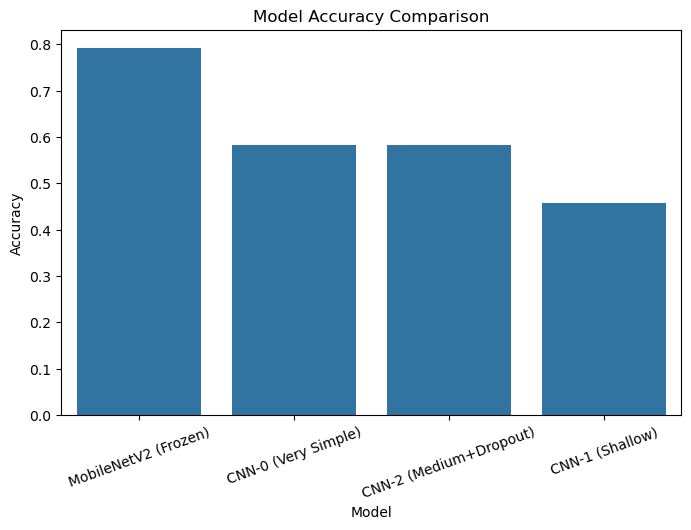

In [12]:
#  Final Model Comparison Table 

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

results = []

def evaluate_model(name, model):
    preds = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes[:len(y_pred)]
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})

# Collect metrics
evaluate_model("CNN-0 (Very Simple)", cnn0)
evaluate_model("CNN-1 (Shallow)", cnn1)
evaluate_model("CNN-2 (Medium+Dropout)", cnn2)
evaluate_model("MobileNetV2 (Frozen)", mn_model)

# Show comparison
res_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print(res_df)

plt.figure(figsize=(8,5))
sns.barplot(data=res_df, x="Model", y="Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=20)
plt.show()


### Final model
* After comparing multiple CNN models (Simple, Shallow, Dropout) with MobileNetV2(frozen),  
the results show that **MobileNetV2** provides the **best performance** on the rice leaf dataset.

In [19]:
# Save MobileNetV2 (Frozen) as final model
mn_model.save("RiceLeaf_MobileNetV2_Frozen.h5")
print("MobileNetV2 (Frozen) saved successfully!")


MobileNetV2 (Frozen) saved successfully!


In [21]:
# Save label map (class names)
with open("label_map.json", "w") as f:
    json.dump(train_gen.class_indices, f)
print(" Label map saved as label_map.json")

 Label map saved as label_map.json
